# Exploratory Analysis – Customer Value Intelligence System

This notebook explores the ecommerce dataset used in the project.

It focuses on:
- Understanding basic customer behavior
- Visualizing Recency, Frequency, and Monetary (RFM) patterns
- Looking at product category affinity and geography
- Generating plots that support the final segmentation and CLV analysis

All heavy lifting (cleaning, feature engineering) is done via the modular code in `src/`.


In [7]:
# import os
# import sys
# from pathlib import Path


# # If this notebook is inside `notebooks/`, go one level up to project root
# project_root = Path(os.getcwd()).parent
# os.chdir(project_root)

# # Make sure root is on sys.path so `src` is importable
# sys.path.append(str(project_root))

# print("CWD:", os.getcwd())
# print("Project root on sys.path:", project_root)


# # get the project root (one level up from notebooks/)
# project_root = Path(os.getcwd()).parent
# sys.path.append(str(project_root))

# print("Project root added to sys.path:", project_root)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_prep import load_raw_data, clean_transactions
from src.rfm_features import build_feature_matrix

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)


In [ ]:
df_raw = load_raw_data()
df = clean_transactions(df_raw)

print("Raw rows:", len(df_raw))
print("Cleaned rows:", len(df))
print("Customers:", df["CustomerID"].nunique())
print("Date range:", df["InvoiceDate"].min(), "→", df["InvoiceDate"].max())

df.head()

Raw rows: 541909
Cleaned rows: 392692
Customers: 4338
Date range: 2010-12-01 08:26:00 → 2011-12-09 12:50:00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Basic Dataset Checks

We quickly inspect the structure of the cleaned transactional data.


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  object        
 7   Country      392451 non-null  object        
 8   TotalPrice   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 30.0+ MB


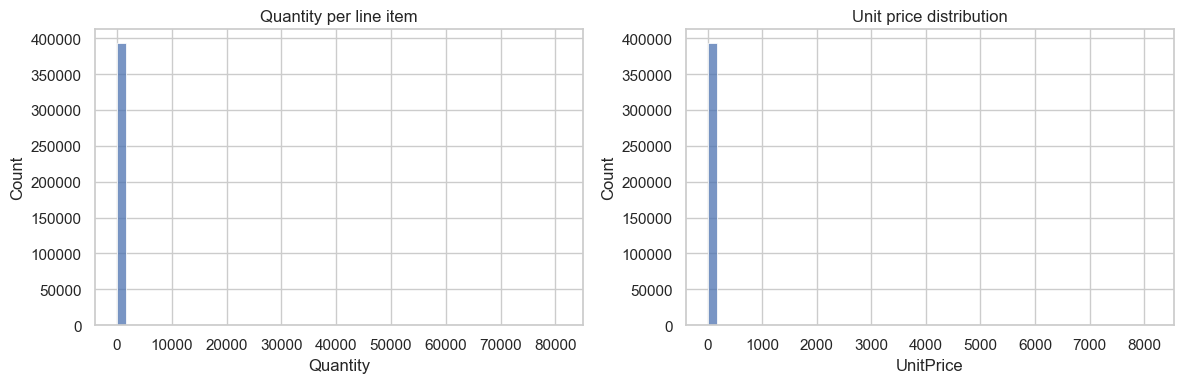

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(df["Quantity"], bins=50, ax=ax[0])
ax[0].set_title("Quantity per line item")

sns.histplot(df["UnitPrice"], bins=50, ax=ax[1])
ax[1].set_title("Unit price distribution")

plt.tight_layout()
plt.show()


## Build Customer-Level Features (RFM, Categories, Geography)

We now aggregate transactions to the customer level using the production code in `src/`.
This ensures the notebook stays consistent with the modeling pipeline.


In [11]:
features = build_feature_matrix(df)
print("Customer-level features shape:", features.shape)
features.head()


Customer-level features shape: (4338, 11)


,CustomerID,Recency,Frequency,Monetary,CatShare_Bags,CatShare_HomeDecor,CatShare_Kitchen,CatShare_Other,CatShare_Toys,PrimaryCountry,IsUK
0,12346.0,326,1,77183.60,0.000000,0.000000,0.000000,1.000000,0.000000,United Kingdom,1.0
1,12347.0,2,7,4310.00,0.110766,0.112278,0.050487,0.712548,0.013921,Iceland,0.0
2,12348.0,75,4,1797.24,0.000000,0.000000,0.000000,1.000000,0.000000,Finland,0.0
3,12349.0,19,1,1757.55,0.007510,0.034082,0.078723,0.879685,0.000000,Italy,0.0
4,12350.0,310,1,334.40,0.061005,0.000000,0.000000,0.938995,0.000000,Norway,0.0


## RFM Distributions

These plots show how recently, how often, and how much customers buy.


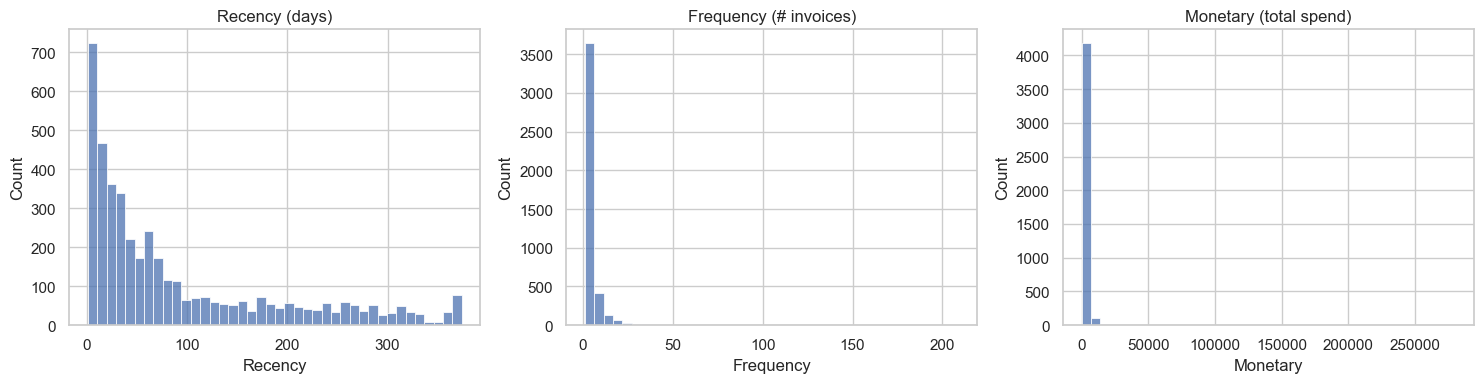

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(features["Recency"], bins=40, ax=ax[0])
ax[0].set_title("Recency (days)")

sns.histplot(features["Frequency"], bins=40, ax=ax[1])
ax[1].set_title("Frequency (# invoices)")

sns.histplot(features["Monetary"], bins=40, ax=ax[2])
ax[2].set_title("Monetary (total spend)")

plt.tight_layout()
plt.show()


## Geographic Distribution (Primary Country)

We look at where most customers are based.


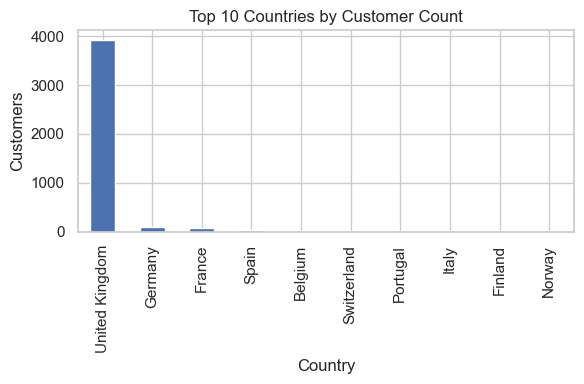

PrimaryCountry
United Kingdom    3920
Germany             94
France              87
Spain               28
Belgium             23
Switzerland         21
Portugal            19
Italy               14
Finland             12
Norway              10
Name: CustomerCount, dtype: int64

In [13]:
country_counts = (
    features["PrimaryCountry"]
    .value_counts()
    .head(10)
    .rename("CustomerCount")
)

country_counts.plot(kind="bar")
plt.title("Top 10 Countries by Customer Count")
plt.xlabel("Country")
plt.ylabel("Customers")
plt.tight_layout()
plt.show()

country_counts


## Product Category Affinity

Using simple keyword-based category mapping, each customer has revenue shares across:
- Home Decor
- Kitchen
- Bags
- Toys
- Other

We examine average category mix across the base.


In [14]:
cat_cols = [c for c in features.columns if c.startswith("CatShare_")]
cat_cols, features[cat_cols].head()


(['CatShare_Bags',
  'CatShare_HomeDecor',
  'CatShare_Kitchen',
  'CatShare_Other',
  'CatShare_Toys'],
    CatShare_Bags  CatShare_HomeDecor  CatShare_Kitchen  CatShare_Other  \
 0       0.000000            0.000000          0.000000        1.000000   
 1       0.110766            0.112278          0.050487        0.712548   
 2       0.000000            0.000000          0.000000        1.000000   
 3       0.007510            0.034082          0.078723        0.879685   
 4       0.061005            0.000000          0.000000        0.938995   
 
    CatShare_Toys  
 0       0.000000  
 1       0.013921  
 2       0.000000  
 3       0.000000  
 4       0.000000  )

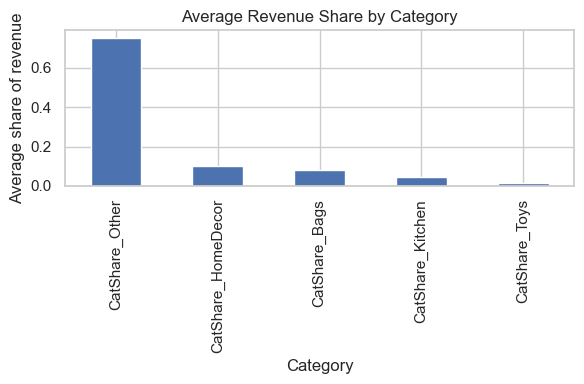

In [15]:
features[cat_cols].mean().sort_values(ascending=False).plot(kind="bar")
plt.title("Average Revenue Share by Category")
plt.xlabel("Category")
plt.ylabel("Average share of revenue")
plt.tight_layout()
plt.show()


## RFM Correlations

Understanding how Recency, Frequency, and Monetary relate to each other helps interpret later modeling.


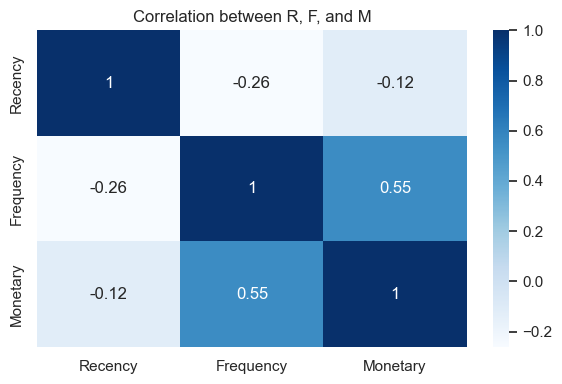

In [16]:
sns.heatmap(
    features[["Recency", "Frequency", "Monetary"]].corr(),
    annot=True,
    cmap="Blues"
)
plt.title("Correlation between R, F, and M")
plt.tight_layout()
plt.show()


## Export Key Figures for Reports

Optionally, we can run the figure-generating script to create PNGs for the PDF/report.


In [17]:
import subprocess

subprocess.run(["python", "generate_figures.py"])


Using cluster column: Cluster_KMeans
Saved reports/figures/rfm_distributions.png
Saved reports/figures/segment_revenue_share.png
Saved reports/figures/clv_by_segment_boxplot.png
Saved reports/figures/recency_frequency_scatter.png
Saved reports/figures/revenue_by_country.png


CompletedProcess(args=['python', 'generate_figures.py'], returncode=0)

# Summary

From this exploratory analysis:

- The dataset shows a long-tail distribution where most customers are low-frequency buyers.
- The United Kingdom dominates both customer count and revenue.
- A few product categories (especially Home Decor and Kitchen) contribute a large share of revenue.
- RFM distributions support the use of RFM + CLV modeling and clustering for segmentation.

This notebook provides the exploratory context behind the production pipeline and dashboard.
